> Jiahui Tang

**System Specs**:
* Kernal:
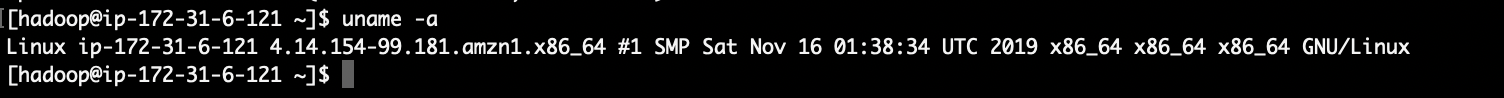
* Infra: 

    * Local Mode: EC2 instance (m4.xlarge) with Ubuntu 18.04. 
    * Cluster: AWS EMR Spark with 2/4 worker instances on m4.xlarge

* Network of Cluster:
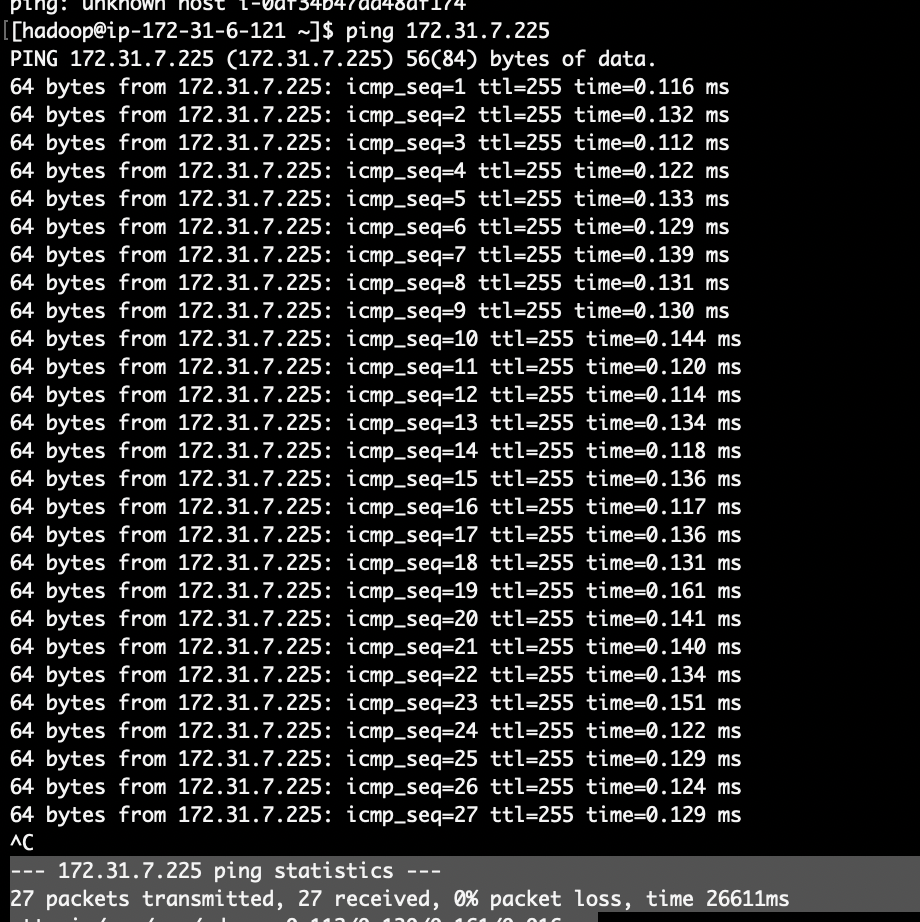

* Bandwidth: Amazon says it’s 5 Gbps
* Spark Version: 
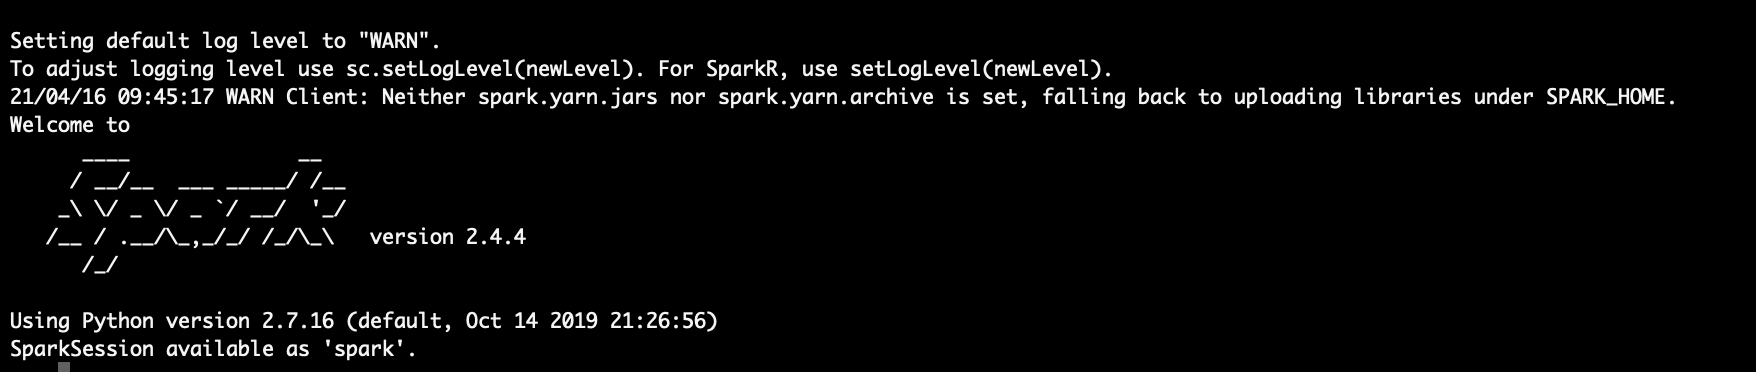

* Java Version:
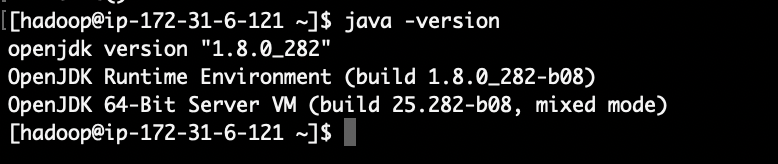

* CPU info:
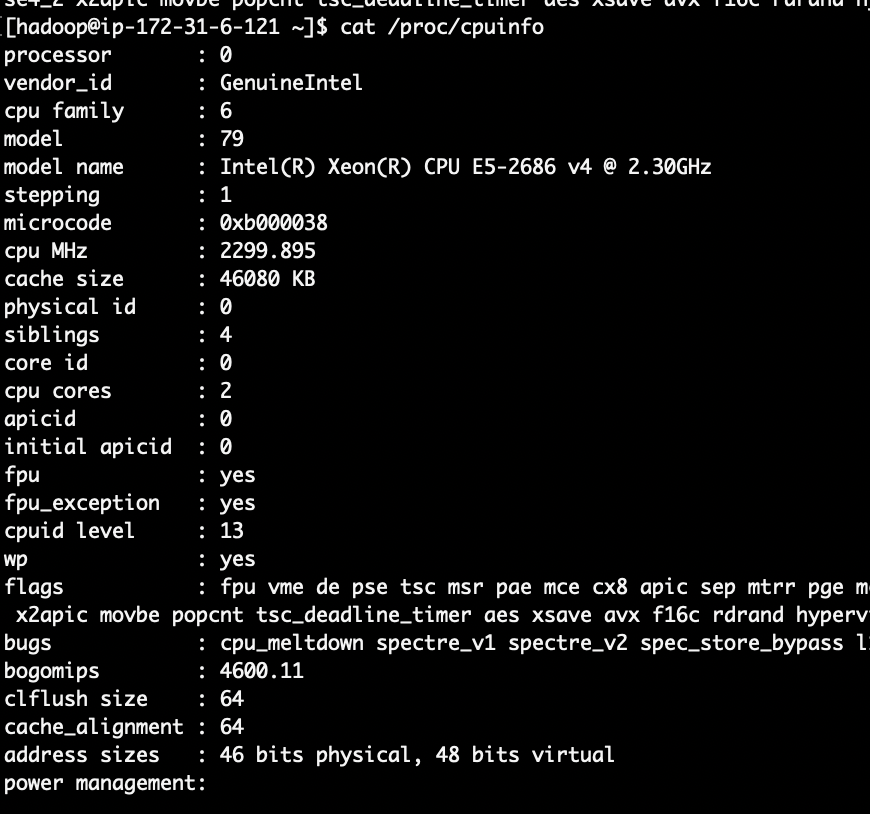
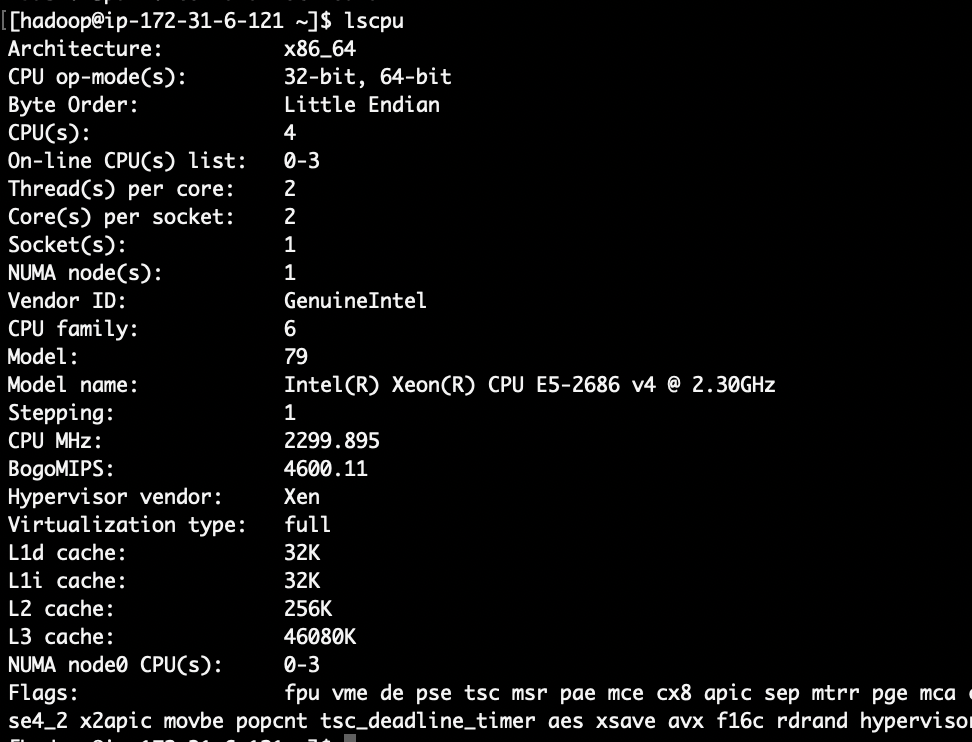


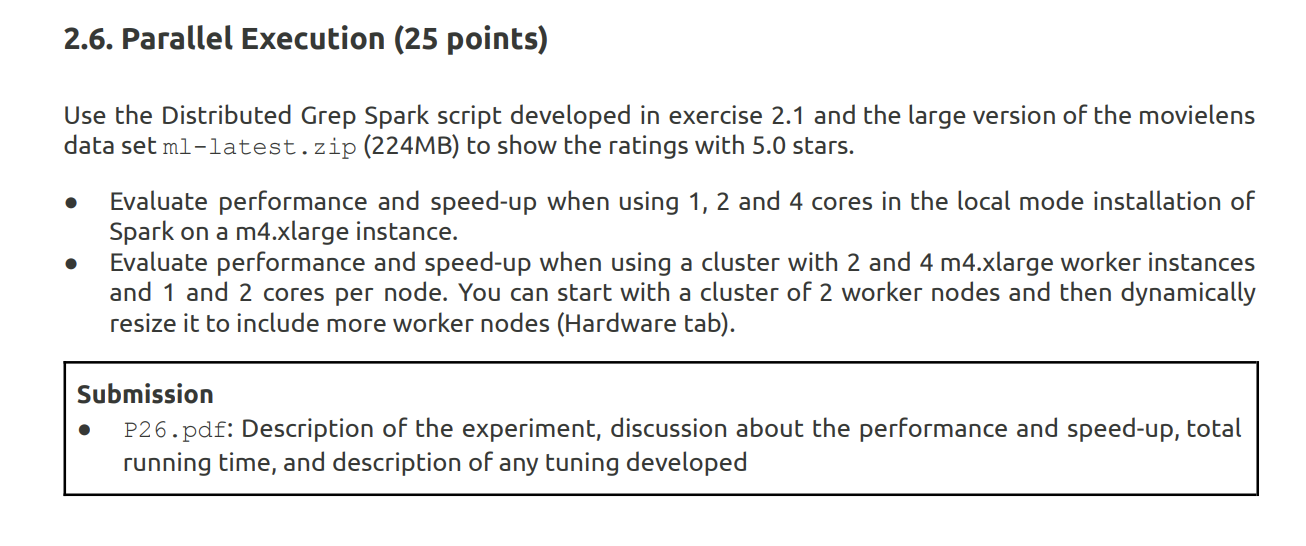

# Part 1: Local Mode

**Result**

| Workder Instances/Core Nodes      | Log Time (sec)| Speedup     |
| :---        |    :----:   |          ---: |
| 1 core     | 51.7817   | 1   |
| 2 cores  | 32.0380       | 1.6163      |
| 4 cores    | 31.508265       | 1.6434      |

**Discussion**:

Similarly to question **1.6**, `grep` is a command-line utility for searching plain-text data sets for lines that match a regular expression. Its name comes from the ed command g/re/p (globally search for a regular expression and print matching lines), which has the same effect. 

From the result table, we could see that after we increase the core node in local mode installation of Spark on m4.xlarge instance, the log time didn't decrease a lot, and speedup also only increase from `1` to `1.61` and `1.64`, for node increases from `1` to `2` and `4` respectively.

It is mainly because of `grep` has a I/O bound, rather than CPU bound (In CPU we only check for `5.0 in line`).

As the `EXECUTION_TIME = CPU_TIME + I/O_TIME + SYSTEM_TIME`, when we increase the node, we could decrease `CPU_TIME` as it is being parallelized. However, as we are doing grep and search for the same pattern, the read and write data part takes a large amount of total execution time, which also keeps unchanged even when the nodes are increased. Thus, as `I/O_TIME` keeps unchanged, while provisioning and shuffle data into more nodes may take more time in Hadoop job, `SYSTEM_TIME` may also be increase, which shows overhead overall is proportional to the number of workers. The total speedup would thus be way less than theortical speed up when number of nodes increases.

We could infer that when increase from 1 core to 2 cores, although it is I/O bounded, it is likely that I/O bound is not fully utilised, thus we see considerable improvement of speedup from 1 to 1.6. When increase from 2 to 4 cores, the speedup is maintained at around 1.6, and not improved much, which means I/O bandwidth is fully utilised.



# Part 2: Cluster

**Result**

| Worker Instances/Core Nodes      | Execution Time (sec) | Speedup |
| :---        |    :----:   |          ---: |
| 2 Worker Instances, 1 core per node    | 57.466414   | 1   |
| 2 Worker Instances, 2 cores per node | 44.580397       | 1.2891      |
| 4 Worker Instances, 1 core per node    | 41.339823   | 1.3901   |
| 4 Worker Instances, 2 core per node    | 26.663581   | 2.1552   |


**Discussion**:

On top of what I said in last question, similarly, `grep` is bounded by I/O time but not CPU time in its total execution time. The performance bottleneck is on input and output, reading and writing. Though I/O could also be parallelized, it has its hard limit on I/O bandwidth and could never reach theortical speedup.

From the performance and speedup, we could observe that 4 workers are overall better than 2 worker instance, while both increasing cores per nodes and number of instances didn't make the speedup reach theortical speedup.
 
As data are in S3, the I/O happens between instances and S3, instead of between instances themselves. So theortically, when we increase number of worker instances to 2 times, the total I/O bandwidth increases proportionally at 2 times. 

From observation, we could infer that in one worker instance, the I/O bandwidth can be fully utilised by 2 cores but it is not enough. It means I/O bandwidth/ability is roughly between 1 to 2 cores. 
Thus, from the table above we could infer that:

* (1). 2 instance and 1 core per node, I/O not fully utilised.
* (2). 2 instance and 2 cores per node, I/O fully utilised, it is bounded by I/O bandwidth. 
*(3). 4 instances and 1 core per node, I/O not fully utilised; Thus it is still not yet bounded by I/O bandwidth, so its speedup is more than what we see in (2)
*(4). 4 instances but with I/O fully utilised, so it reaches the maximum speedup among 4 cases. However, it is still way less than theortical speedup as there's overhead proportional to number of worker instances, and I/O time is bounded by its bandwidth.

# Part 3: Description of Experiment on Local Mode


**Description of Experiment**:
1. Spin up Ubuntu 18.04 EC2 Instance with m4.xlarge and follow guide in [Lab 9](https://harvard-iacs.github.io/2021-CS205/labs/I9/I9.pdf)
2. Install Scala, Java, Python and Spark
3. Configure Environment by updating `.profile` and `/etc/hosts`
4. Install `unzip` by running `sudo apt install unzip`
5. Upload Python file `P26_spark.py` to ubuntu and the large version of MovieLens dataset and unzip it. 
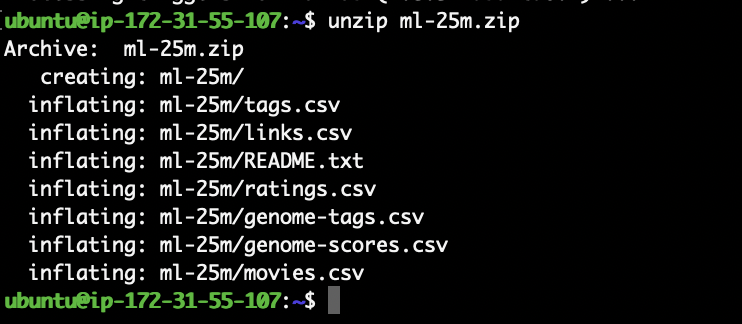


6. Copy out the `ratings.csv` file to current directory by `cp ml-25m/ratings.csv ./`
7. Submit a spark job with 1 core in local mode, checking for execution time for 1 core is `51.7817 sec`

Using cmd `spark-submit P26_spark.py`

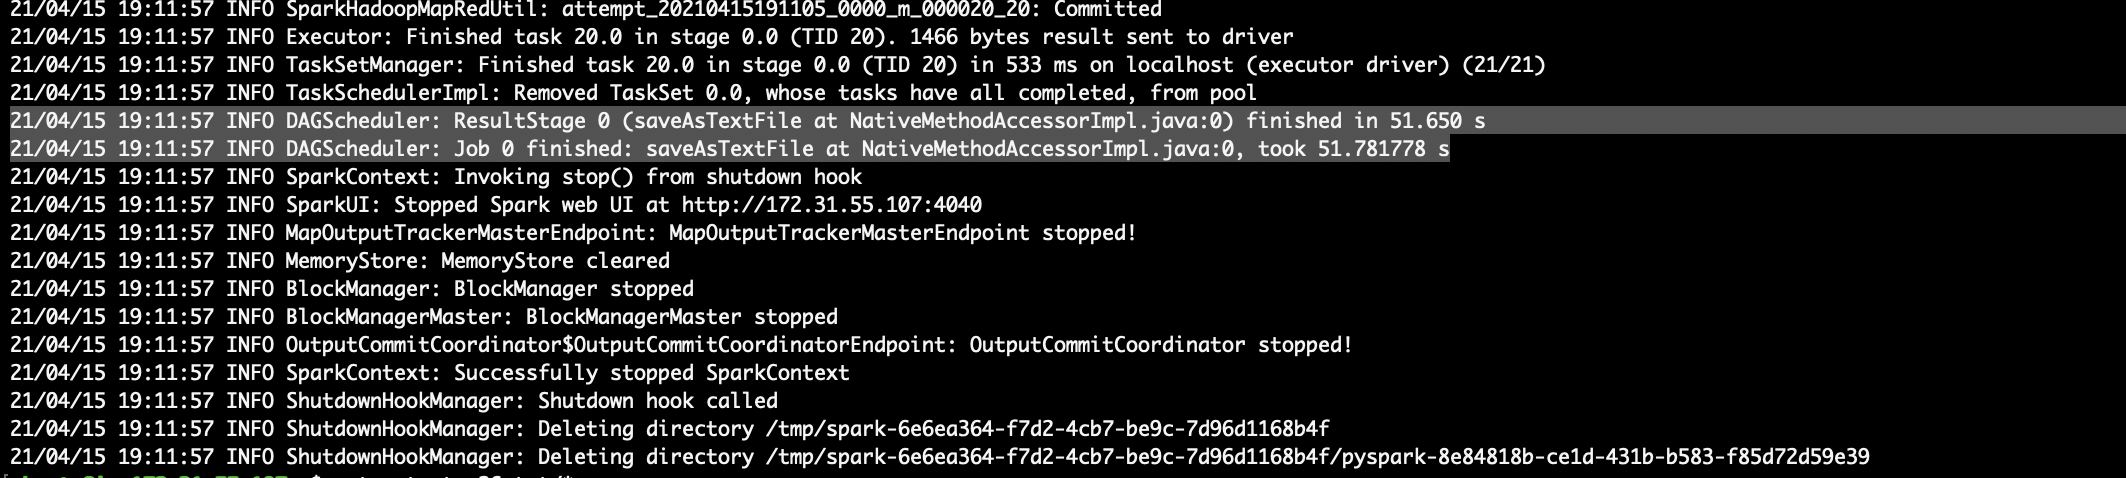

8. Check output is correct by `cat output_q26.txt/*`
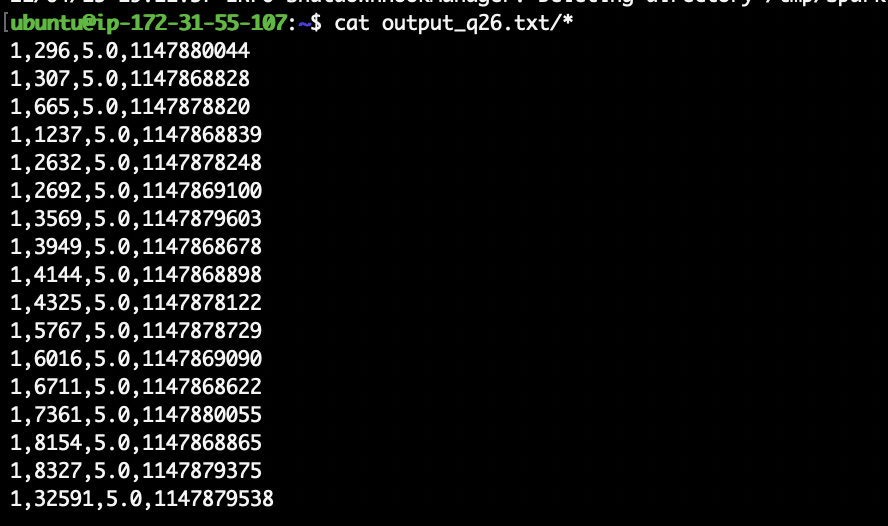

9.Make a copy of original file and update it with 2 cores

by changing `setMaster(local[2])`: Run Spark locally with 2 worker threads (ideally, set this to the number of cores on your machines).

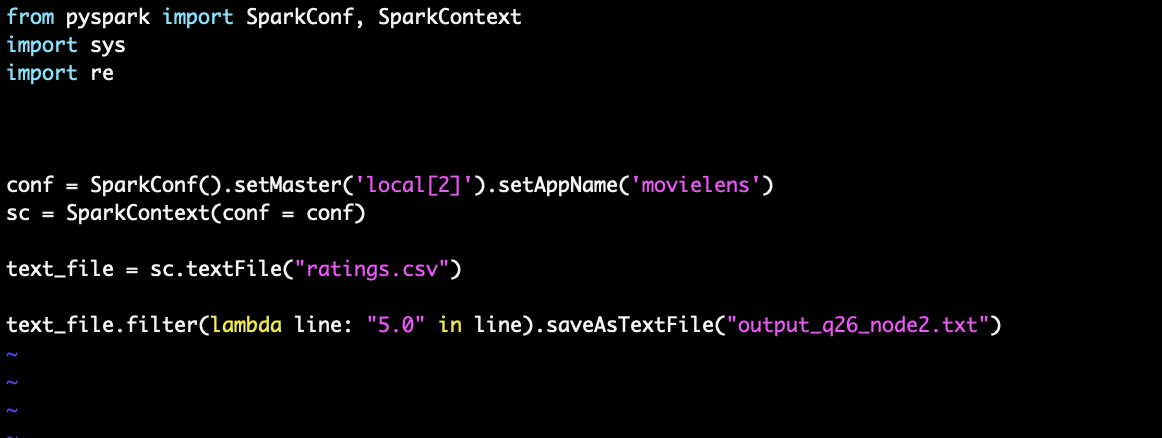

10. Resubmit spark job and check execution time for 2 cores is `32.0380`.
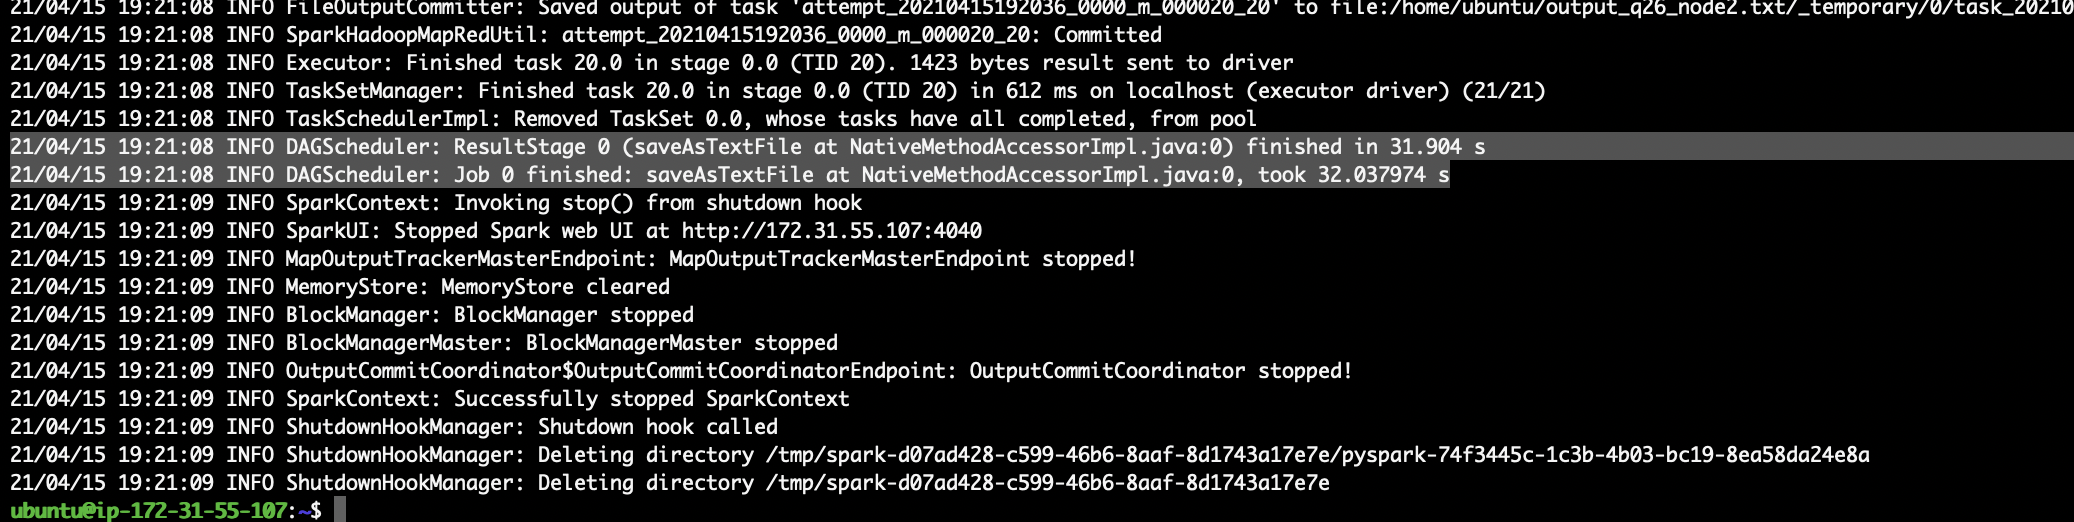

11. Simlarly, repeat step 9-10 for 4 cores, and get execution time for 4 cores is `31.508265`.

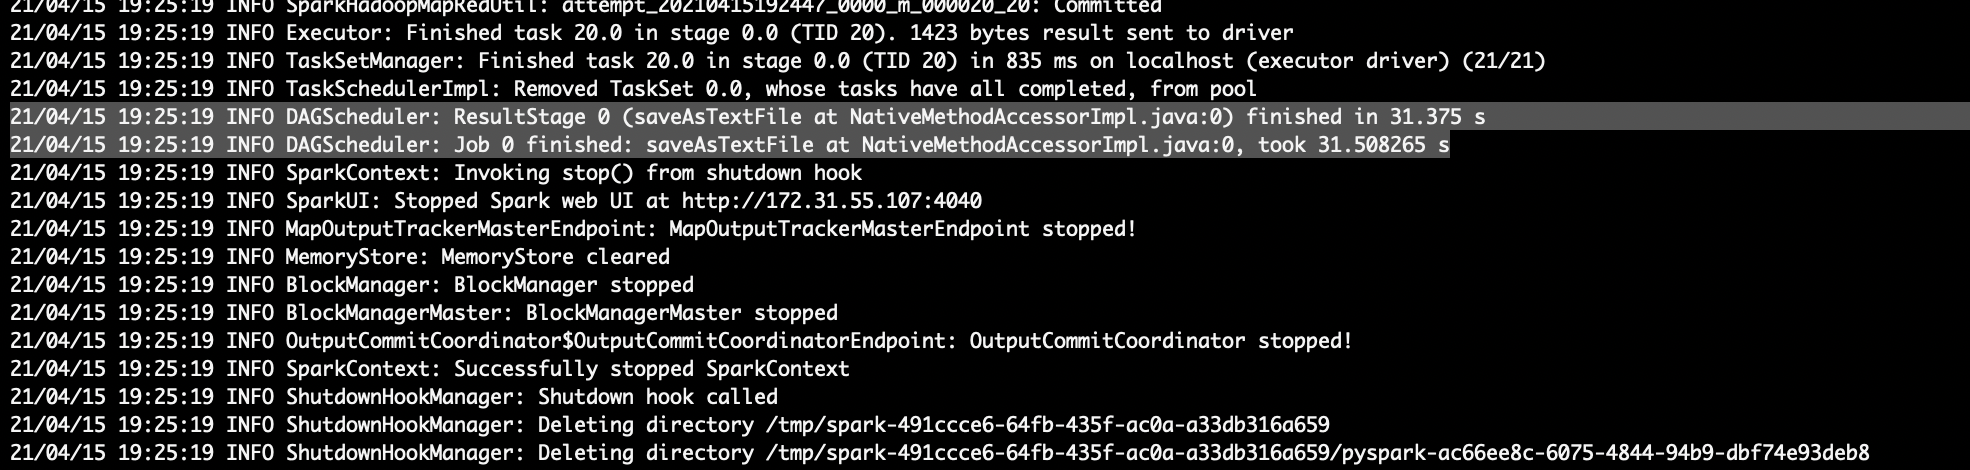

# Part 4: Description of Experiment on Cluster


**Description of Experiment**:
1. Spin up Hadoop EMR cluster with m4.xlarge and follow guide in [Lab 10](https://harvard-iacs.github.io/2021-CS205/labs/I10/I10.pdf)
2. Upload Python file `P26_spark.py` to ubuntu and the large version of MovieLens dataset and unzip it. 
3. Copy out the `ratings.csv` file to current directory by `cp ml-25m/ratings.csv ./`
4. Upload the ratings.csv file to the Hadoop file system

`hadoop fs -put ratings.csv`
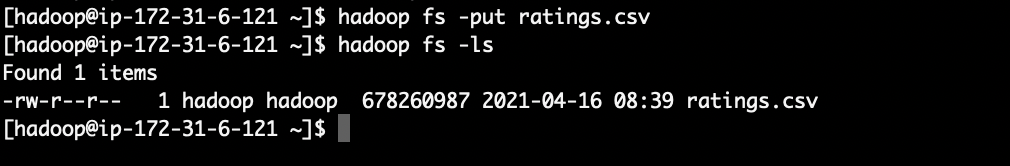

5. Submit a spark job with 2 worker instance and 1 core per node in local mode, by specifying `--executor-cores` and `--num-executors` in command line, also remove the setMaster property with local in the SparkConf configuration.

It takes `57.466414` execution time.


cmd: `spark-submit --num-executors 2 --executor-cores 1 P26_spark.py`

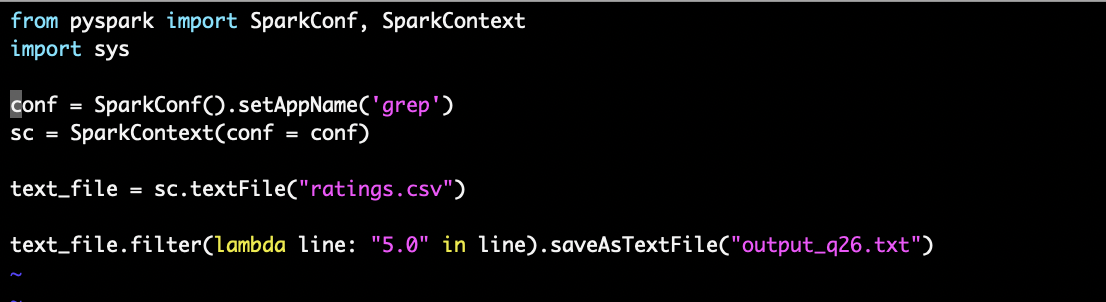
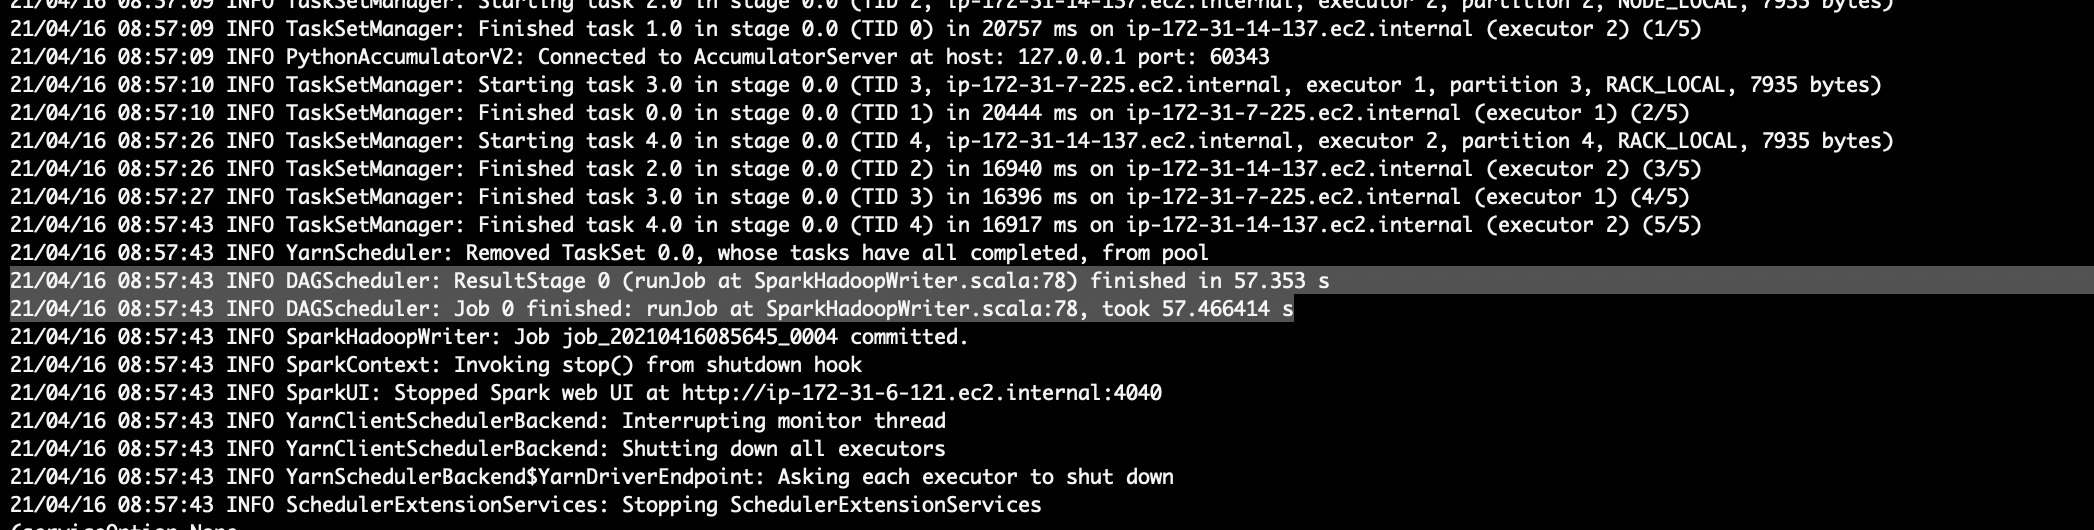

6. Download the output file from hadoop file system to the local file system and check the content is correct
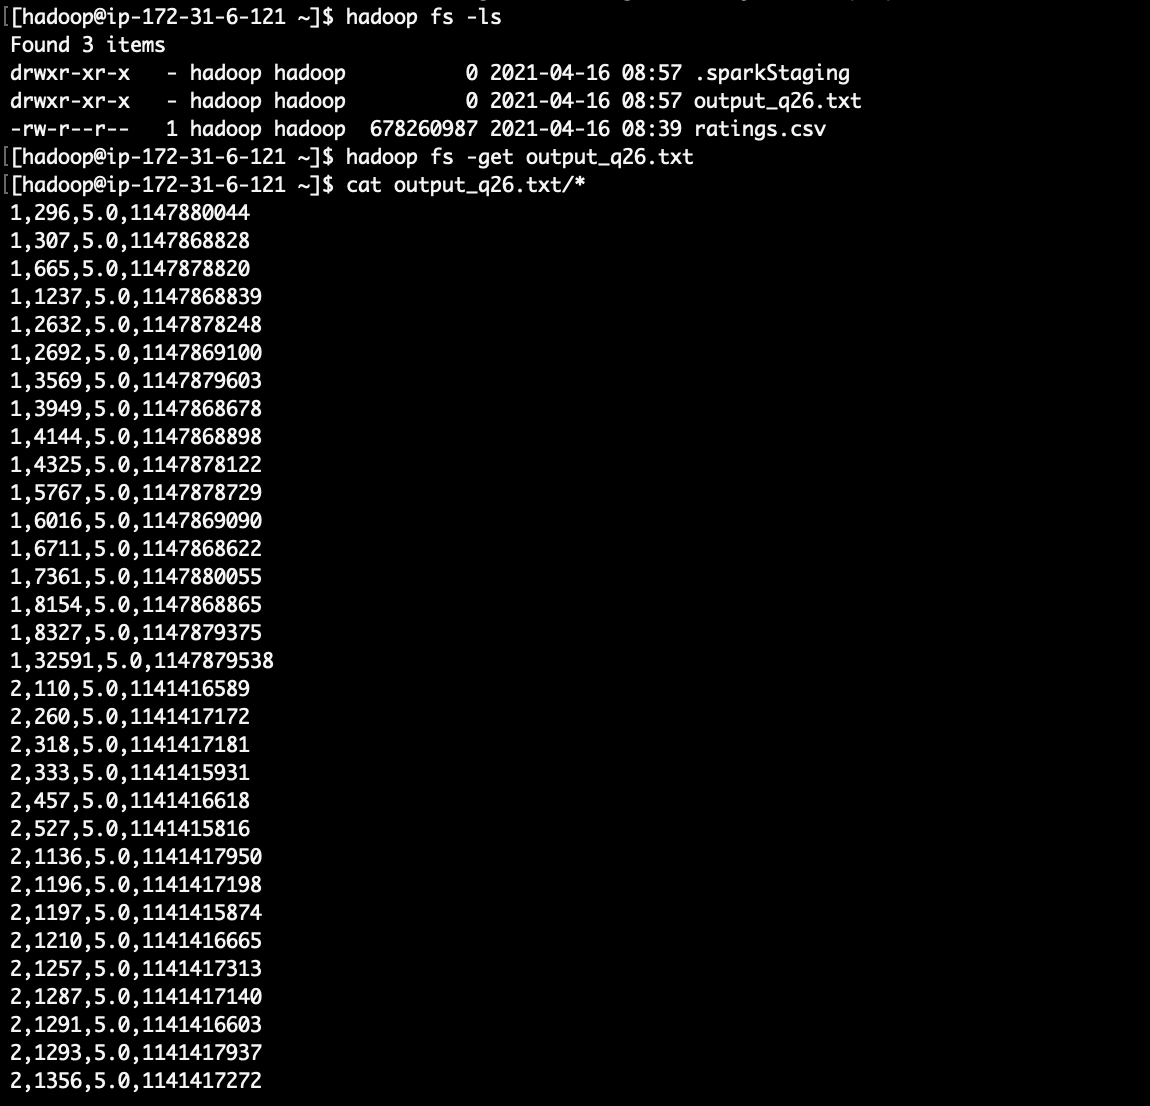


7. Remove existing output file 

`hadoop fs -rm -R -f output_q26.txt`

8. Similarly, submit a spark job with 2 worker instance and 2 core per node in local mode, by specifying `--executor-cores` and `--num-executors` in command line, also remove the setMaster property with local in the SparkConf configuration.

It takes `44.580397` seconds execution time.

cmd: `spark-submit --num-executors 2 --executor-cores 2 P26_spark.py`

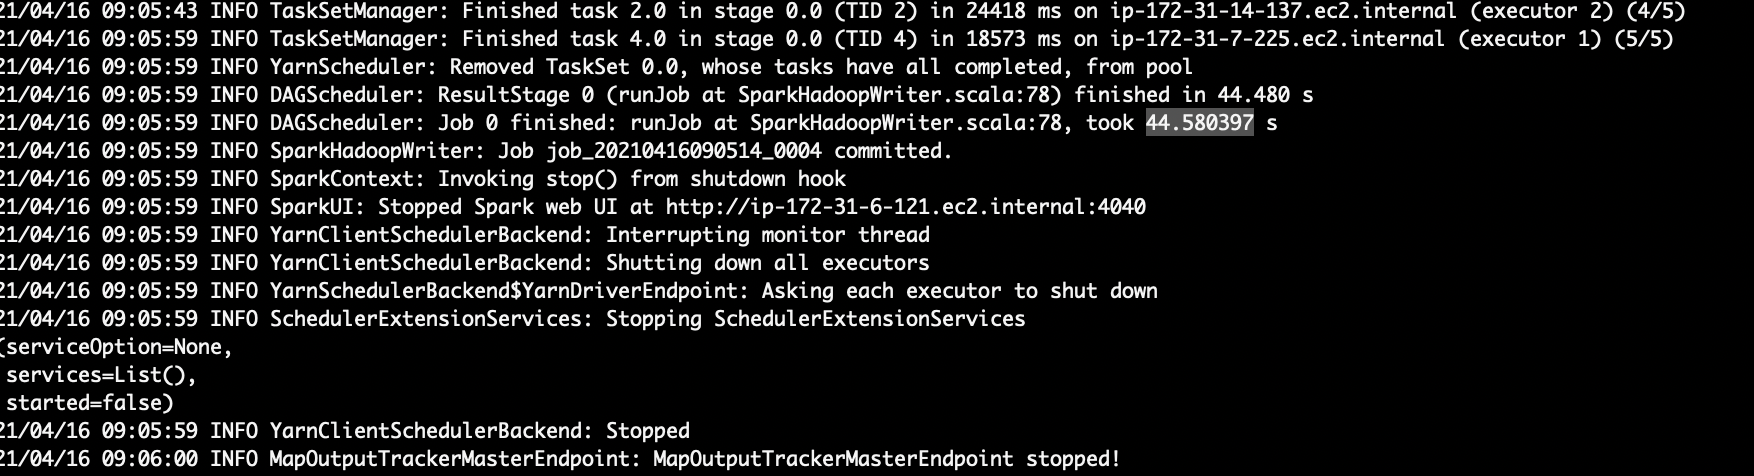

8. Resize to `4` worker instance/core nodes and redo step 5-8.

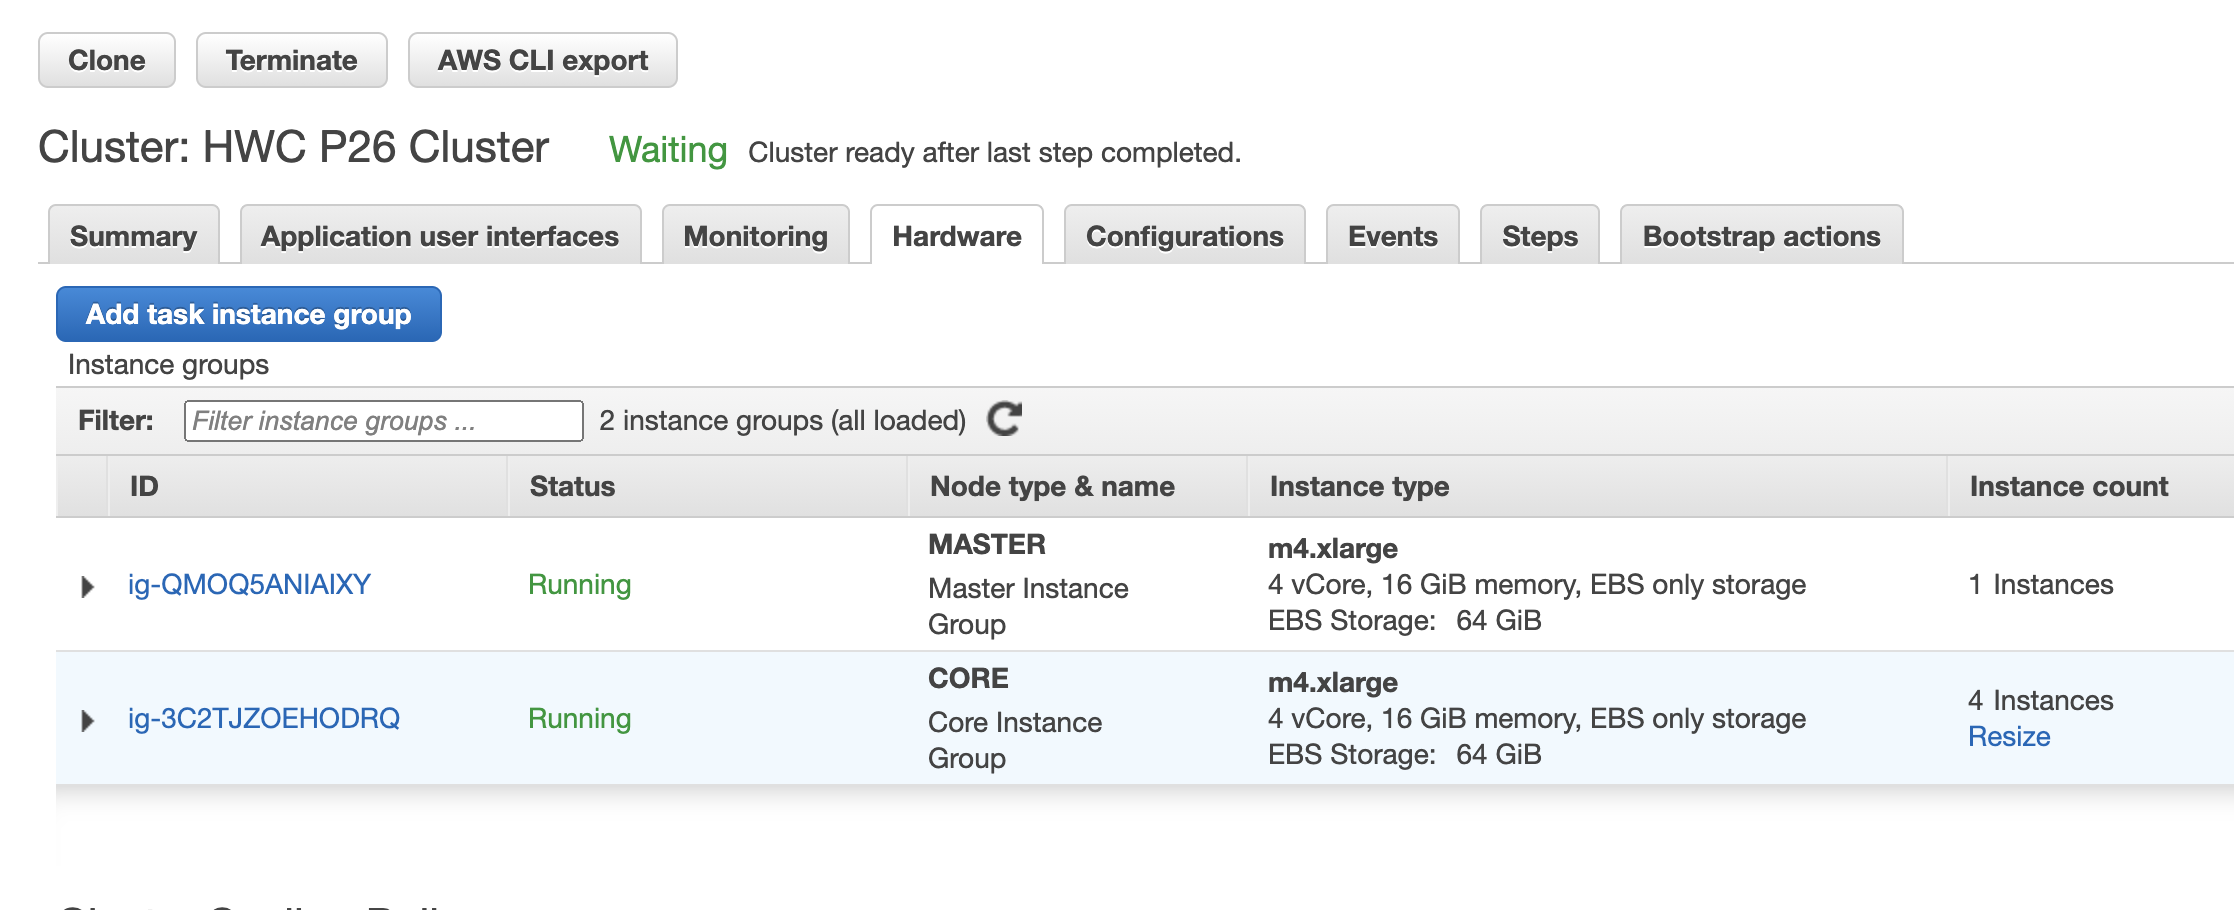

9. Submit Spark job with 4 worker instances and 1 core per node.

`spark-submit --num-executors 4 --executor-cores 1 P26_spark.py`

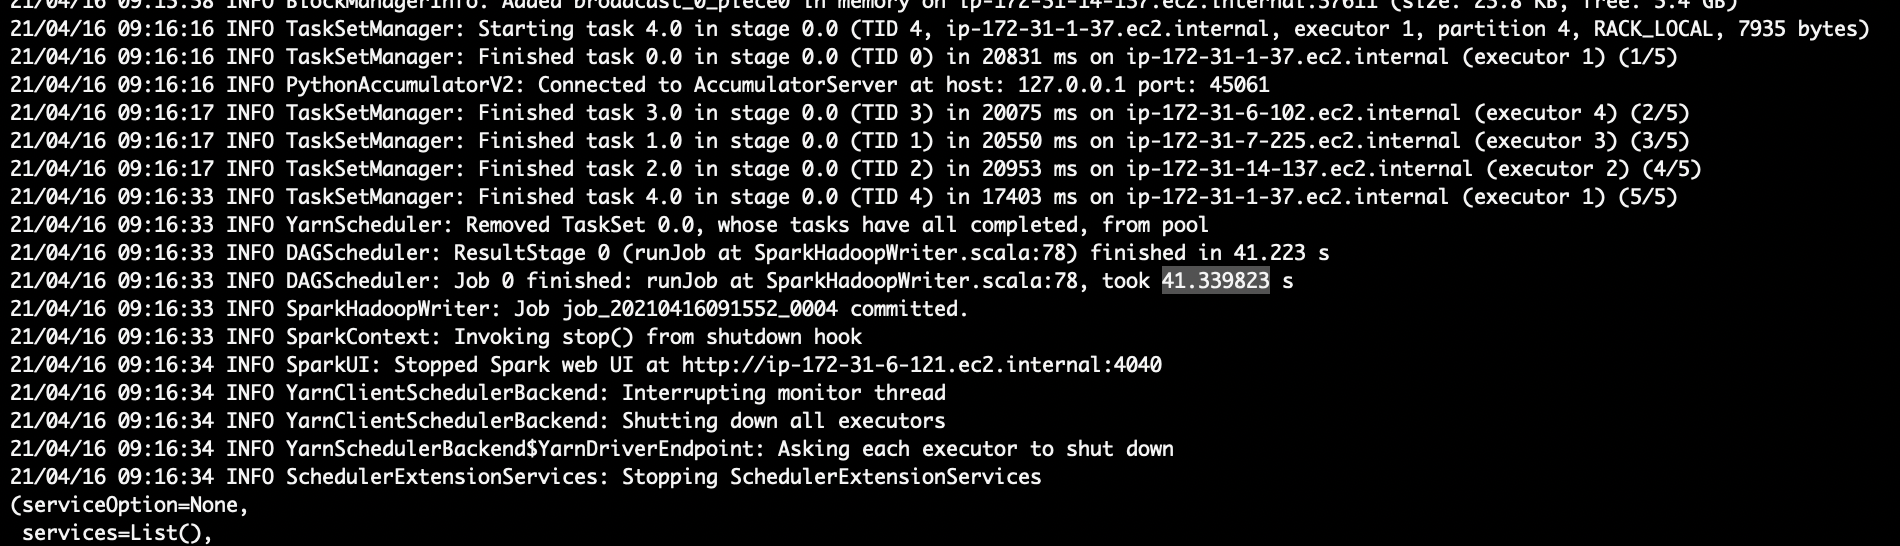

10. Submit Spark job with 4 worker instances and 2 core per node.

`spark-submit --num-executors 4 --executor-cores 2 P26_spark.py`

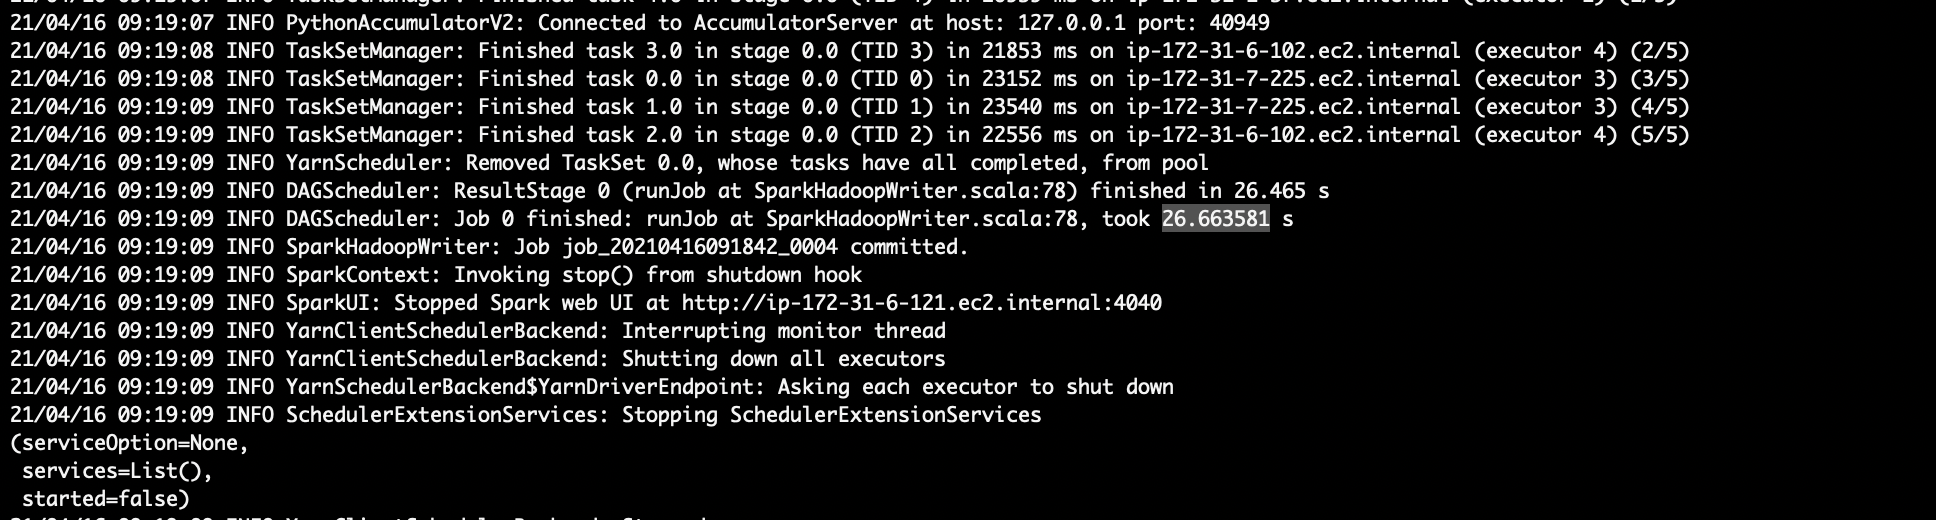